In [1]:
%cd "/home/albin/skolarbete/DML_LAsegmentation"

/home/albin/skolarbete/DML_LAsegmentation


In [2]:
from scripts.train import train, validate, patched_forward
from scripts.utils import CombinedLoss
from models.unet import UNet3D, NormalizationType
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from monai.networks.nets import UNETR, SwinUNETR
from transformers import get_cosine_schedule_with_warmup
from scripts.dataset import TrainDataset, TestDataset

sns.set_theme(style="whitegrid")
custom_palette = ["#D32F2F", "#1976D2", "#4CAF50"]  # Red, Blue, Light Green
sns.set_palette(custom_palette)

In [3]:
val_image_path = 'data/Task02_Heart/imagesVl'
val_label_path = 'data/Task02_Heart/labelsVl'

patch_size = (64, 128, 128)
val_dataset = TestDataset(val_image_path, val_label_path, scale_intensity=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=4)

In [4]:
# Load UNet3D model results
file_name_unet3d = 'unet_model_results.pkl'
with open(file_name_unet3d, 'rb') as f:
    data_unet3d = pickle.load(f)
    best_model_unet3d = UNet3D(in_channels=1, out_channels=1, features=[32, 64, 128, 256], normalization=NormalizationType.GROUP_NORM)
    best_model_unet3d.load_state_dict(data_unet3d['model_state'])
    results_unet3d = (best_model_unet3d, data_unet3d['train_metrics'], data_unet3d['val_metrics'])

best_model_unet3d, results_train_unet3d, results_val_unet3d = results_unet3d

# Load UNETR model results
file_name_unetr = 'unetR_model_results.pkl'
with open(file_name_unetr, 'rb') as f:
    data_unetr = pickle.load(f)
    best_model_unetr = UNETR(in_channels=1, out_channels=1, img_size=(64, 128, 128))
    best_model_unetr.load_state_dict(data_unetr['model_state'])
    results_unetr = (best_model_unetr, data_unetr['train_metrics'], data_unetr['val_metrics'])

best_model_unetr, results_train_unetr, results_val_unetr = results_unetr

# Load SwinUNETR model results
file_name_swinunetr = 'swinUnetR_model_results.pkl'
with open(file_name_swinunetr, 'rb') as f:
    data_swinunetr = pickle.load(f)
    best_model_swinunetr = SwinUNETR(in_channels=1, out_channels=1, img_size=(64, 128, 128))
    best_model_swinunetr.load_state_dict(data_swinunetr['model_state'])
    results_swinunetr = (best_model_swinunetr, data_swinunetr['train_metrics'], data_swinunetr['val_metrics'])

best_model_swinunetr, results_train_swinunetr, results_val_swinunetr = results_swinunetr

/home/albin/miniconda3/envs/dml/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


In [5]:
results_val_unet3d.keys()

dict_keys(['loss', 'iou', 'dice'])

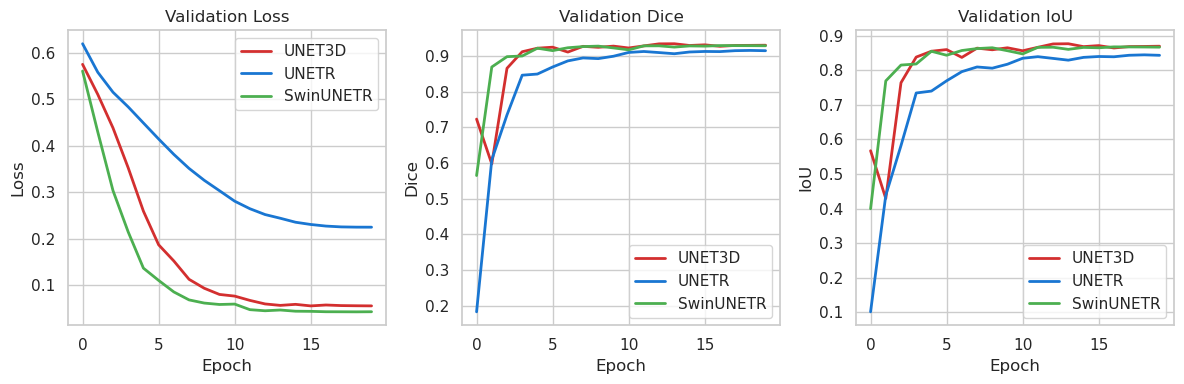

In [6]:
# Create a DataFrame for validation metrics
val_metrics_df = pd.DataFrame({
    'Epoch': range(len(results_val_unet3d['loss'])),
    'UNET3D_Loss': results_val_unet3d['loss'],
    'UNETR_Loss': results_val_unetr['loss'],
    'SwinUNETR_Loss': results_val_swinunetr['loss'],
    'UNET3D_Dice': results_val_unet3d['dice'],
    'UNETR_Dice': results_val_unetr['dice'],
    'SwinUNETR_Dice': results_val_swinunetr['dice'],
    'UNET3D_IoU': results_val_unet3d['iou'],
    'UNETR_IoU': results_val_unetr['iou'],
    'SwinUNETR_IoU': results_val_swinunetr['iou']
})

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot validation loss
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='UNET3D_Loss', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='UNETR_Loss', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[0], data=val_metrics_df, x='Epoch', y='SwinUNETR_Loss', label='SwinUNETR', linewidth=2)
axes[0].set_title('Validation Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot validation dice
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='UNET3D_Dice', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='UNETR_Dice', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[1], data=val_metrics_df, x='Epoch', y='SwinUNETR_Dice', label='SwinUNETR', linewidth=2)
axes[1].set_title('Validation Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot validation IoU
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='UNET3D_IoU', label='UNET3D', linewidth=2)
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='UNETR_IoU', label='UNETR', linewidth=2)
sns.lineplot(ax=axes[2], data=val_metrics_df, x='Epoch', y='SwinUNETR_IoU', label='SwinUNETR', linewidth=2)
axes[2].set_title('Validation IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')

# Add grid to the plots
for ax in axes:
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

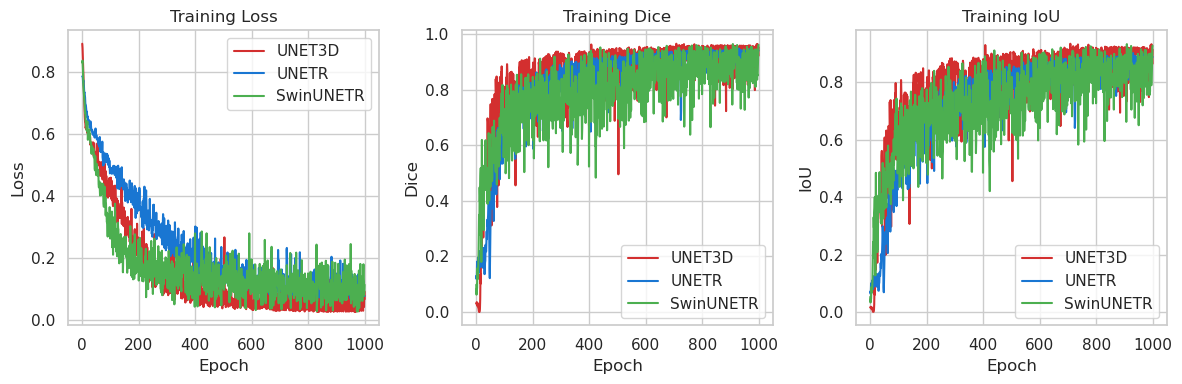

In [7]:
# Create a DataFrame for training metrics
train_metrics_df = pd.DataFrame({
    'Epoch': range(len(results_train_unet3d['loss'])),
    'UNET3D_Loss': results_train_unet3d['loss'],
    'UNETR_Loss': results_train_unetr['loss'],
    'SwinUNETR_Loss': results_train_swinunetr['loss'],
    'UNET3D_Dice': results_train_unet3d['dice'],
    'UNETR_Dice': results_train_unetr['dice'],
    'SwinUNETR_Dice': results_train_swinunetr['dice'],
    'UNET3D_IoU': results_train_unet3d['iou'],
    'UNETR_IoU': results_train_unetr['iou'],
    'SwinUNETR_IoU': results_train_swinunetr['iou']
})

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot training loss
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='UNET3D_Loss', label='UNET3D')
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='UNETR_Loss', label='UNETR')
sns.lineplot(ax=axes[0], data=train_metrics_df, x='Epoch', y='SwinUNETR_Loss', label='SwinUNETR')
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot training dice
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='UNET3D_Dice', label='UNET3D')
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='UNETR_Dice', label='UNETR')
sns.lineplot(ax=axes[1], data=train_metrics_df, x='Epoch', y='SwinUNETR_Dice', label='SwinUNETR')
axes[1].set_title('Training Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot training IoU
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='UNET3D_IoU', label='UNET3D')
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='UNETR_IoU', label='UNETR')
sns.lineplot(ax=axes[2], data=train_metrics_df, x='Epoch', y='SwinUNETR_IoU', label='SwinUNETR')
axes[2].set_title('Training IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')


# Add grid to the plots
for ax in axes:
    ax.grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

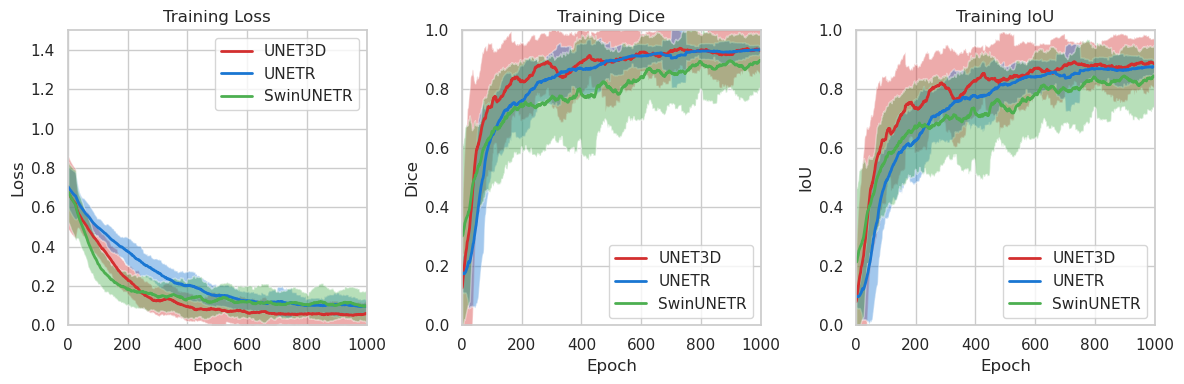

In [8]:
# Calculate rolling mean and standard deviation
window_size = 50
alpha_ = 0.4
line_width = 2  # Parameter to change the line width

train_metrics_df['UNET3D_Loss_Mean'] = train_metrics_df['UNET3D_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_Loss_Std'] = train_metrics_df['UNET3D_Loss'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_Loss_Mean'] = train_metrics_df['UNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_Loss_Std'] = train_metrics_df['UNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_Loss_Mean'] = train_metrics_df['SwinUNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_Loss_Std'] = train_metrics_df['SwinUNETR_Loss'].rolling(window=window_size, min_periods=1, center=True).std()

train_metrics_df['UNET3D_Dice_Mean'] = train_metrics_df['UNET3D_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_Dice_Std'] = train_metrics_df['UNET3D_Dice'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_Dice_Mean'] = train_metrics_df['UNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_Dice_Std'] = train_metrics_df['UNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_Dice_Mean'] = train_metrics_df['SwinUNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_Dice_Std'] = train_metrics_df['SwinUNETR_Dice'].rolling(window=window_size, min_periods=1, center=True).std()

train_metrics_df['UNET3D_IoU_Mean'] = train_metrics_df['UNET3D_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNET3D_IoU_Std'] = train_metrics_df['UNET3D_IoU'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['UNETR_IoU_Mean'] = train_metrics_df['UNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['UNETR_IoU_Std'] = train_metrics_df['UNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).std()
train_metrics_df['SwinUNETR_IoU_Mean'] = train_metrics_df['SwinUNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).mean()
train_metrics_df['SwinUNETR_IoU_Std'] = train_metrics_df['SwinUNETR_IoU'].rolling(window=window_size, min_periods=1, center=True).std()

# Set up the matplotlib figure
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Plot training loss with confidence intervals
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_Loss_Mean'], label='UNET3D', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNET3D_Loss_Mean'] - 1.96 * train_metrics_df['UNET3D_Loss_Std'], 
                     train_metrics_df['UNET3D_Loss_Mean'] + 1.96 * train_metrics_df['UNET3D_Loss_Std'], alpha=alpha_)
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_Loss_Mean'], label='UNETR', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNETR_Loss_Mean'] - 1.96 * train_metrics_df['UNETR_Loss_Std'], 
                     train_metrics_df['UNETR_Loss_Mean'] + 1.96 * train_metrics_df['UNETR_Loss_Std'], alpha=alpha_)
axes[0].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_Loss_Mean'], label='SwinUNETR', linewidth=line_width)
axes[0].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['SwinUNETR_Loss_Mean'] - 1.96 * train_metrics_df['SwinUNETR_Loss_Std'], 
                     train_metrics_df['SwinUNETR_Loss_Mean'] + 1.96 * train_metrics_df['SwinUNETR_Loss_Std'], alpha=alpha_)
axes[0].set_title('Training Loss')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')

# Plot training dice with confidence intervals
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_Dice_Mean'], label='UNET3D', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNET3D_Dice_Mean'] - 1.96 * train_metrics_df['UNET3D_Dice_Std'], 
                     train_metrics_df['UNET3D_Dice_Mean'] + 1.96 * train_metrics_df['UNET3D_Dice_Std'], alpha=alpha_)
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_Dice_Mean'], label='UNETR', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNETR_Dice_Mean'] - 1.96 * train_metrics_df['UNETR_Dice_Std'], 
                     train_metrics_df['UNETR_Dice_Mean'] + 1.96 * train_metrics_df['UNETR_Dice_Std'], alpha=alpha_)
axes[1].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_Dice_Mean'], label='SwinUNETR', linewidth=line_width)
axes[1].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['SwinUNETR_Dice_Mean'] - 1.96 * train_metrics_df['SwinUNETR_Dice_Std'], 
                     train_metrics_df['SwinUNETR_Dice_Mean'] + 1.96 * train_metrics_df['SwinUNETR_Dice_Std'], alpha=alpha_)
axes[1].set_title('Training Dice')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Dice')

# Plot training IoU with confidence intervals
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['UNET3D_IoU_Mean'], label='UNET3D', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNET3D_IoU_Mean'] - 1.96 * train_metrics_df['UNET3D_IoU_Std'], 
                     train_metrics_df['UNET3D_IoU_Mean'] + 1.96 * train_metrics_df['UNET3D_IoU_Std'], alpha=alpha_)
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['UNETR_IoU_Mean'], label='UNETR', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['UNETR_IoU_Mean'] - 1.96 * train_metrics_df['UNETR_IoU_Std'], 
                     train_metrics_df['UNETR_IoU_Mean'] + 1.96 * train_metrics_df['UNETR_IoU_Std'], alpha=alpha_)
axes[2].plot(train_metrics_df['Epoch'], train_metrics_df['SwinUNETR_IoU_Mean'], label='SwinUNETR', linewidth=line_width)
axes[2].fill_between(train_metrics_df['Epoch'], 
                     train_metrics_df['SwinUNETR_IoU_Mean'] - 1.96 * train_metrics_df['SwinUNETR_IoU_Std'], 
                     train_metrics_df['SwinUNETR_IoU_Mean'] + 1.96 * train_metrics_df['SwinUNETR_IoU_Std'], alpha=alpha_)
axes[2].set_title('Training IoU')
axes[2].set_xlabel('Epoch')
axes[2].set_ylabel('IoU')

# Set seaborn theme
sns.set_theme(style="whitegrid")

# Add grid to the plots
for ax in axes:
    ax.grid(True)
    ax.legend()
    ax.set_xlim(0, 1000)
    if ax == axes[0]:
        ax.set_ylim(0, 1.5)
    else:
        ax.set_ylim(0, 1)

# Adjust layout
plt.tight_layout()
plt.show()